In [4]:
#ante-MMPBSA.py -p 0.15_80_10_pH7.5_6m0j_trunc_final.top -r ACE2_dry_trunc.prmtop -l SARS-CoV-2-spike_dry_trunc.prmtop -m :1-339
# WARNING: -m is recepter residue number not atom number
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from rdkit import Chem
from deepchem.feat.graph_features import atom_features as get_atom_features
import rdkit
import pickle
import matplotlib.pyplot as plt
import importlib
import keras.backend as K
from sklearn.utils import shuffle

%cd ../../PGGCN/
import models.layers_update_mobley as layers
importlib.reload(layers)
from models.dcFeaturizer import atom_features as get_atom_features
%cd ../Notebooks/Entropy
PDBs = pickle.load(open('PDBs_RDKit.pkl', 'rb'))


2023-11-09 18:13:40.794717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 18:13:40.978179: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-09 18:13:40.979636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-09 18:13:41.801820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


/home/ali/GBNN/PGGCN
/home/ali/GBNN/Notebooks/Entropy


In [3]:
def featurize(molecule, info, exclude=None):
    
    atom_features = []
    for atom in molecule.GetAtoms():
        new_feature = get_atom_features(atom).tolist()
        position = molecule.GetConformer().GetAtomPosition(atom.GetIdx())
        new_feature += [atom.GetMass(), atom.GetAtomicNum()]
        new_feature += [position.x, position.y, position.z]
        for neighbor in atom.GetNeighbors()[:2]:
            neighbor_idx = neighbor.GetIdx()
            new_feature += [neighbor_idx]
        for i in range(2 - len(atom.GetNeighbors())):
            new_feature += [-1]

        if exclude != None:
            for i in exclude:
                new_feature.pop(i)

        atom_features.append(np.concatenate([new_feature, info], 0))
    return np.array(atom_features)


In [28]:

class PGGCNModel(tf.keras.Model):
    def __init__(self, num_atom_features = 36, r_out_channel = 20, c_out_channel = 128):
        super().__init__()
        self.ruleGraphConvLayer = layers.RuleGraphConvLayer(r_out_channel, num_atom_features, 0)
        self.ruleGraphConvLayer.combination_rules = []
        self.conv = layers.ConvLayer(c_out_channel)
        self.dense1 = tf.keras.layers.Dense(64, activation='relu', name='dense1')
        self.dense5 = tf.keras.layers.Dense(16, name='relu')
        self.dense6 = tf.keras.layers.Dense(1, name='dense6')
        self.dense7 = tf.keras.layers.Dense(1, name='dense7',
                 kernel_initializer=tf.keras.initializers.Constant([-.2, -1, 1, 1]),
                 bias_initializer=tf.keras.initializers.Zeros())
        self.all_layer_1_weights = []
        
    def addRule(self, rule, start_index, end_index = None):
        self.ruleGraphConvLayer.addRule(rule, start_index, end_index)
    
    def set_input_shapes(self, i_s):
        self.i_s = i_s

    def call(self, inputs):
        physics_info = inputs[:,0,38-2:]
        x_a = []
        for i in range(len(self.i_s)):
            x_a.append(inputs[i][:self.i_s[i], :38])
        x = self.ruleGraphConvLayer(x_a)
        self.all_layer_1_weights.append(self.ruleGraphConvLayer.w_s)
        x = self.conv(x)
        x = self.dense1(x)
        x = self.dense5(x)
        model_var = self.dense6(x)
        merged = tf.concat([model_var, physics_info], axis=1)
        print(merged)
        print(model_var)
        print(physics_info)
        out = self.dense7(merged)
        return out


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred[0] - y_true))) + K.abs(1 / K.mean(.2 + y_pred[1]))
def pure_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [29]:
def train(X, y, excelude):
    ex = len(excelude)
    m = PGGCNModel(num_atom_features = 36-ex)
    m.addRule("sum", 0, 31-ex)
    m.addRule("multiply", 31-ex, 33-ex)
    m.addRule("distance", 33-ex, 36-ex)

    m.compile(loss=pure_rmse, optimizer='adam')
    X_train, X_test, y_train, y_test = X[:int(.8*len(X))], X[int(.8*len(X)):], y[:int(.8*len(X))], y[int(.8*len(X)):]

    input_shapes = []
    for i in range(len(X_train)):
        input_shapes.append(np.array(X_train[i]).shape[0])
    m.set_input_shapes(input_shapes)
    for i in range(len(X_train)):
        if X_train[i].shape[0] < 2000:
            new_list = np.zeros([2000 - X_train[i].shape[0], X_train[i].shape[-1]])
            X_train[i] = np.concatenate([X_train[i], new_list], 0)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    hist = m.fit(X_train, y_train, epochs = 1, batch_size=100)

    input_shapes = []
    y_test = y[int(.8*len(X)):]
    for i in range(len(X_test)):
        input_shapes.append(np.array(X_test[i]).shape[0])
    m.set_input_shapes(input_shapes)
    for i in range(len(X_test)):
        if X_test[i].shape[0] < 2000:
            new_list = np.zeros([2000 - X_test[i].shape[0], 40])
            X_test[i] = np.concatenate([X_test[i], new_list], 0)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return m.evaluate(X_test, y_test), hist


In [30]:
def experiment(excelude):
    PDBs = pickle.load(open('PDBs_RDKit.pkl', 'rb'))
    df = pd.read_csv('T_data.csv')
    info = []
    for pdb in list(PDBs.keys()):
        info.append(df[df['Id'] == pdb][['TS_comp', 'TS_host', 'TS_ligand']].to_numpy()[0])
    
    X = []
    y = []
    
    for i, pdb in enumerate(list(PDBs.keys())):
        X.append(featurize(PDBs[pdb], info[i], excelude))
        y.append(df[df['Id'] == pdb]['exp'].to_numpy()[0])
    
    return train(X, y , excelude)
    

In [31]:
excelude_list = [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 18, 19]
dic = {}
for ex in excelude_list:
    hist, res = experiment([ex])
    dic[ex] = [hist, res]

Tensor("pggcn_model_3/concat:0", shape=(100, 4), dtype=float32)
Tensor("pggcn_model_3/dense6/BiasAdd:0", shape=(100, 1), dtype=float32)
Tensor("pggcn_model_3/strided_slice:0", shape=(100, 3), dtype=float32)



KeyboardInterrupt



In [5]:
features = ['Carbon', 'Nitrogen', 'Oxygen', 'Sulfur', 'Fluorine', 'Degree 0', 'Degree 1', 'Degree 2',
    'implicit valence 0', 'implicit valence 1', 'implicit valence 2', '# electrons', 'charge']
indices = [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 18, 19]
feature_dict = {indices[i]: features[i] for i in range(len(indices))}

In [2]:
vals = {0: 4.1533, 1:4.1504, 2:4.1526, 3:4.1517, 4:4.1491, 6:4.1503, 7:4.1498, 8:4.1539, 10:4.1530, 11:4.1509, 12: 4.1504, 18: 4.1482, 19:4.1488}

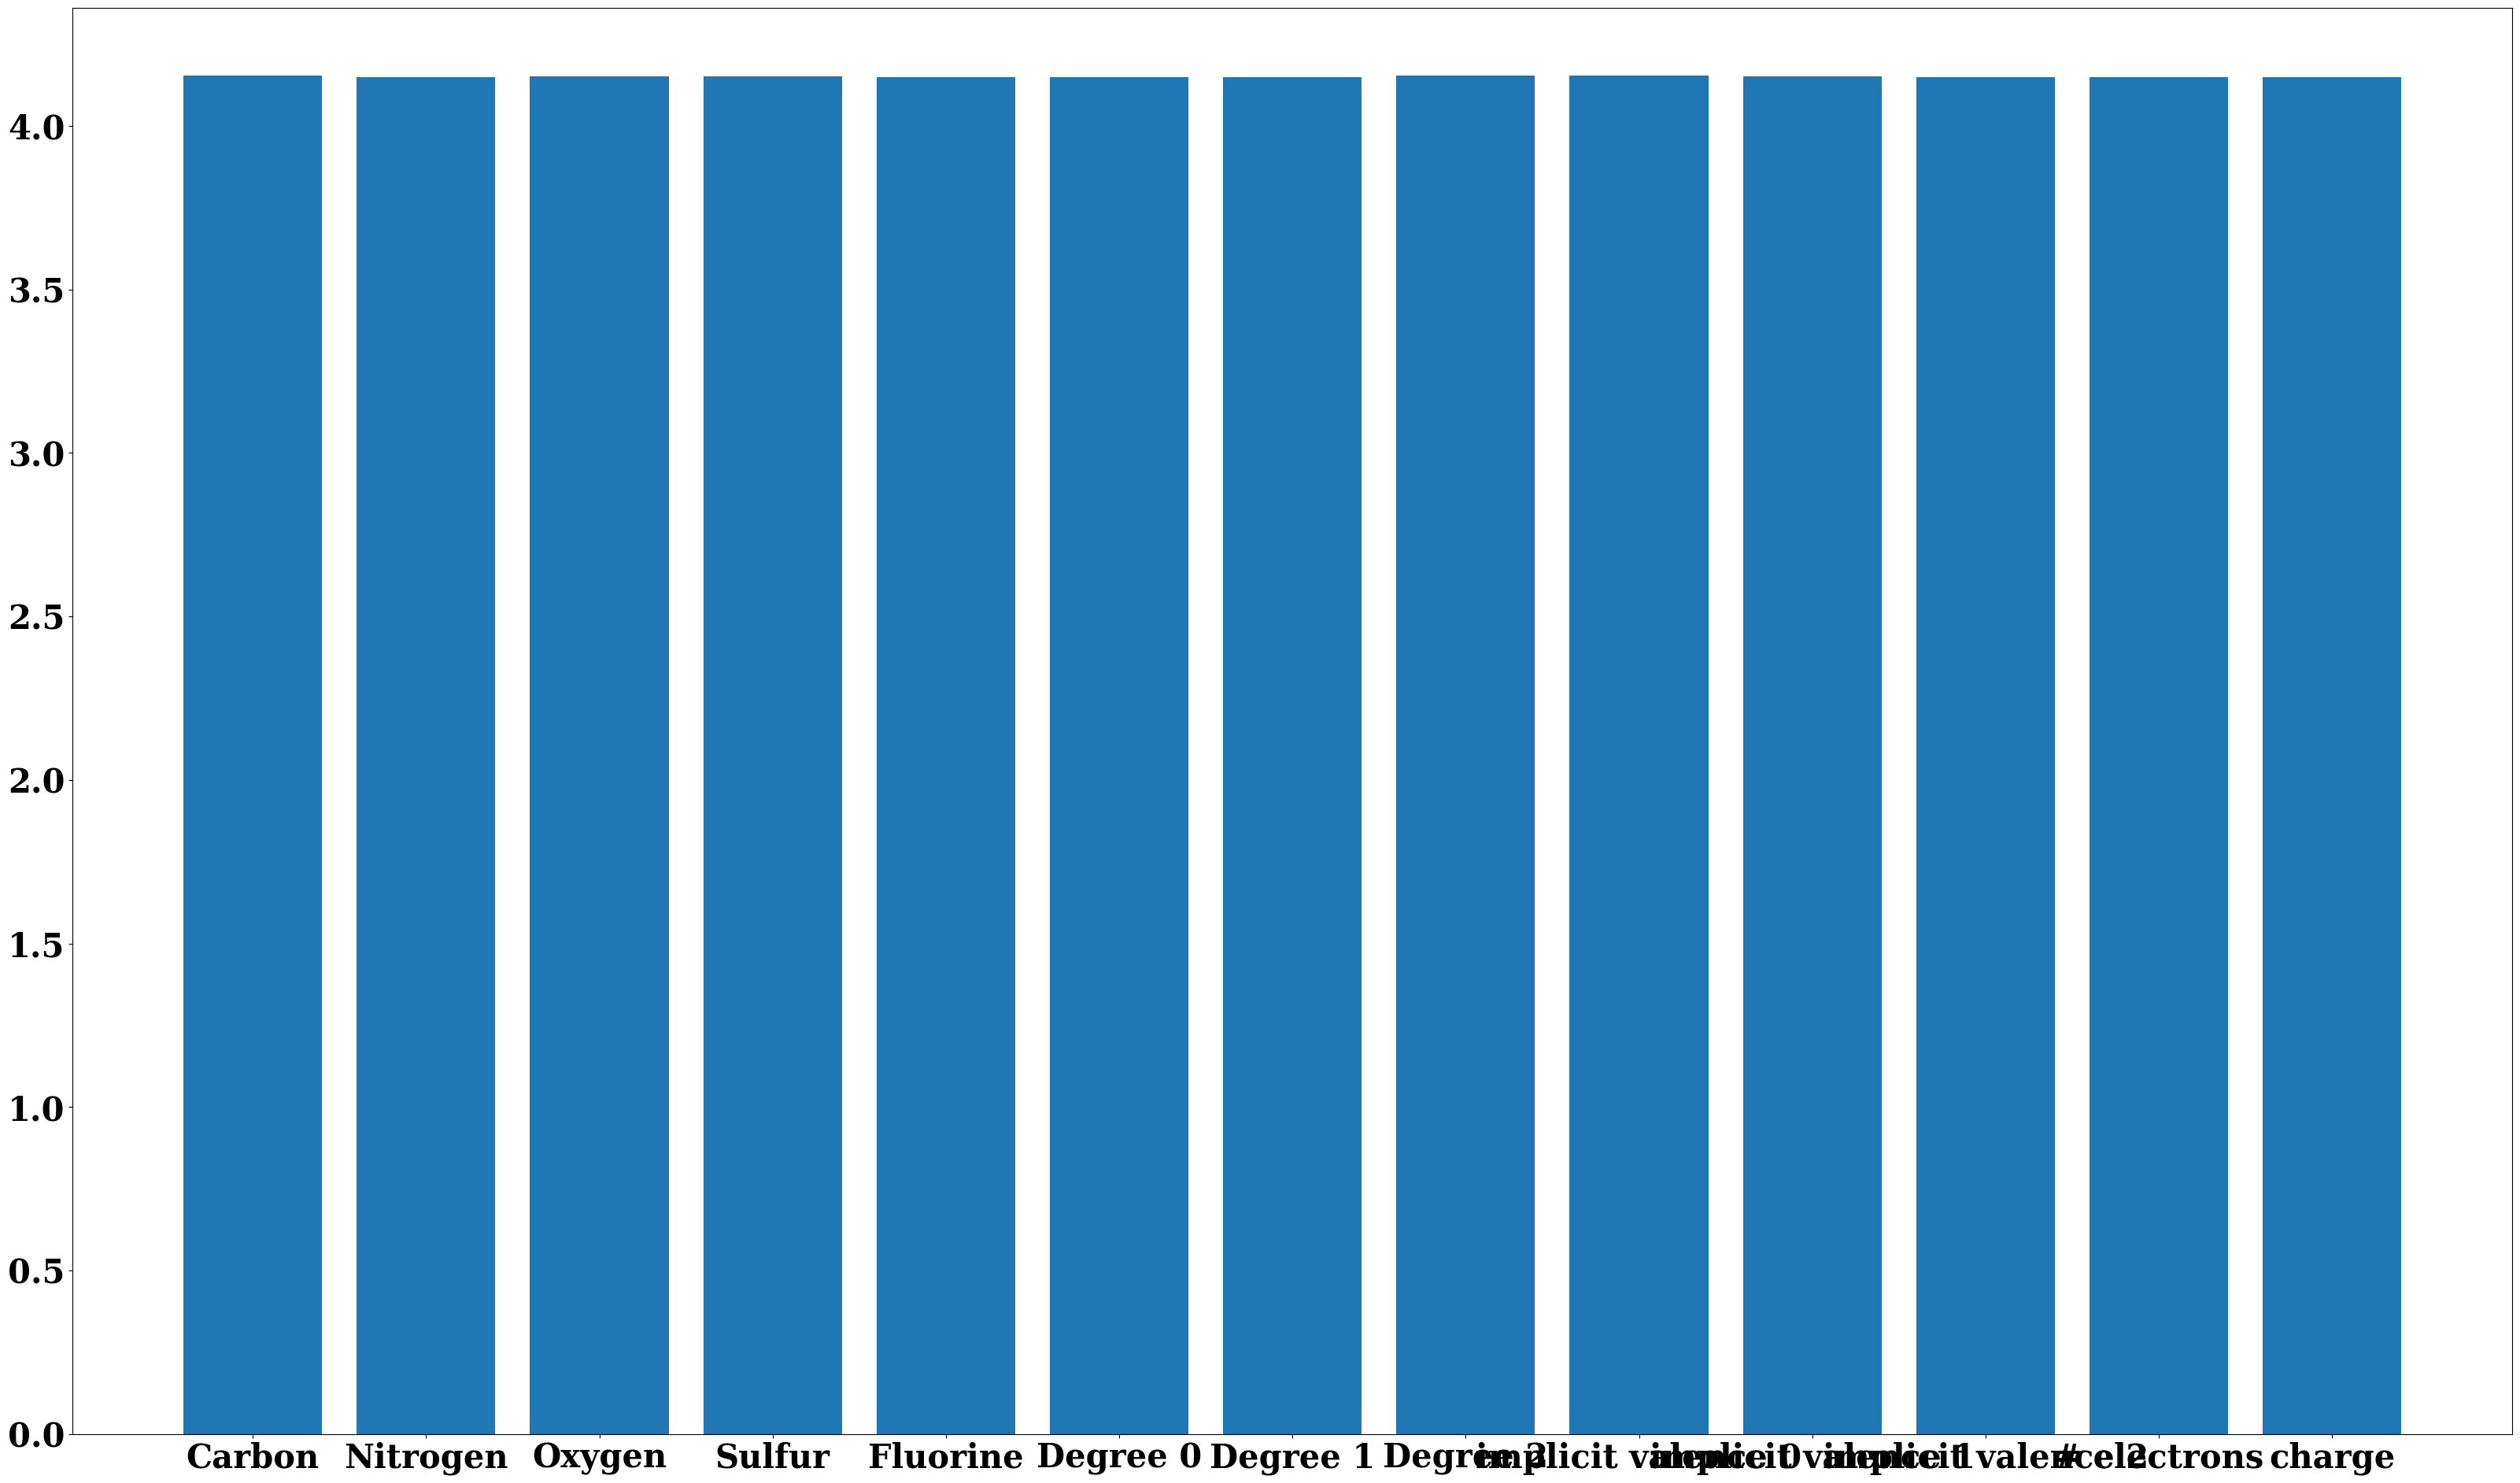

In [17]:
import matplotlib
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
from matplotlib.pyplot import figure
figure(figsize=(40, 24), dpi=100)

plt.bar(features, vals.values())
# plt.xticks(features)
plt.show()

In [8]:
%cd ../../Datasets/VM2_data

/home/ali/GBNN/Datasets/VM2_data


In [13]:
import pandas as pd
df_acd = pd.read_csv('taproom_ACD/MGO_vm2_complex.csv')

In [17]:
df_acd[' S']

0     188.818600
1     181.732404
2     179.633618
3     197.382305
4     204.160569
5     185.191885
6     201.804227
7     196.301052
8     192.270888
9     192.987463
10    204.398609
11    184.153308
12    188.391336
13    197.095563
14    205.087795
15    212.337217
16    196.399300
17    206.323149
18    210.181435
19    197.099926
20    196.755623
21    185.458198
Name:  S, dtype: float64